In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
movies=pd.read_csv('movies.csv')

In [18]:
print(movies.shape)
movies.head()

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [19]:
ratings=pd.read_csv('ratings.csv')

In [20]:
print(ratings.shape)
ratings.head()

(100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


#### Ratings distribution

In [21]:
ratings_dist=ratings.groupby(['rating']).count().reset_index()[['rating','userId',]]
ratings_dist.head()

<class 'pandas.core.frame.DataFrame'>


,rating,userId
0,0.5,1370
1,1.0,2811
2,1.5,1791
3,2.0,7551
4,2.5,5550


Text(0.5, 1.0, 'Distribution of Ratings')

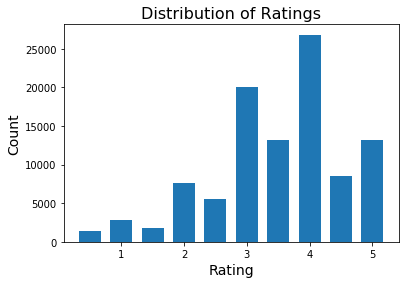

In [22]:
plt.bar(ratings_dist['rating'],ratings_dist['userId'],width = 0.35)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Ratings', fontsize=16)

#### Ratings per movie

1


Text(0.5, 1.0, 'Distribution of Ratings per Movie')

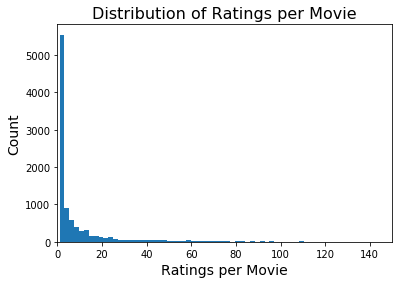

In [23]:
print(min(ratings['movieId'].value_counts()))
plt.hist(ratings['movieId'].value_counts(),bins=150)
plt.xlim(0,150)
plt.xlabel('Ratings per Movie', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Ratings per Movie', fontsize=16)

#### Ratings per user

20


Text(0.5, 1.0, 'Distribution of Ratings per User')

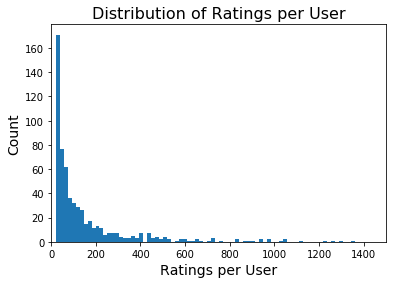

In [24]:
print(min(ratings['userId'].value_counts()))
plt.hist(ratings['userId'].value_counts(),bins=150)
plt.xlim(0,1500)
plt.xlabel('Ratings per User', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Ratings per User', fontsize=16)

In [25]:
# Filter sparse movies
min_movie_ratings = 10
filter_movies = (ratings['movieId'].value_counts()>min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

# Filter sparse users
min_user_ratings = 10
filter_users = (ratings['userId'].value_counts()>min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

# Actual filtering
ratings_filterd = ratings[(ratings['movieId'].isin(filter_movies)) & (ratings['userId'].isin(filter_users))]
del filter_movies, filter_users, min_movie_ratings, min_user_ratings
print('Shape User-Ratings unfiltered:\t{}'.format(ratings.shape))
print('Shape User-Ratings filtered:\t{}'.format(ratings_filterd.shape))

Shape User-Ratings unfiltered:	(100836, 4)
Shape User-Ratings filtered:	(79636, 4)


In [45]:
print('Original Dataset')
print('No of users: {}, No of movies: {}'.format(ratings['userId'].nunique(),ratings['movieId'].nunique()))
print('Rating Density: {}'.format(ratings.shape[0]/(ratings['userId'].nunique()*ratings['movieId'].nunique())))
print('Filtered Dataset')
print('No of users: {}, No of movies: {}'.format(ratings_filterd['userId'].nunique(),ratings_filterd['movieId'].nunique()))
print('Rating Density: {}'.format(ratings_filterd.shape[0]/
                                  (ratings_filterd['userId'].nunique()*ratings_filterd['movieId'].nunique())))

Original Dataset
No of users: 610, No of movies: 9724
Rating Density: 0.016999683055613623
Filtered Dataset
No of users: 610, No of movies: 2121
Rating Density: 0.06155154157101893


In [26]:
# Shuffle DataFrame
ratings_filterd=ratings_filterd.drop('timestamp', axis=1).sample(frac=1).reset_index(drop=True)
ratings_filterd.head()

,userId,movieId,rating
0,275,3751,3.0
1,7,33162,3.5
2,232,4306,4.0
3,470,1073,4.0
4,582,2571,5.0


In [27]:
# Testingsize
n = 16000

# Split train- & testset
df_train = ratings_filterd[:-n]
df_test = ratings_filterd[-n:]

In [28]:
# Create a user-movie matrix with empty values
df_p = df_train.pivot_table(index='userId', columns='movieId', values='rating')
print('Shape User-Movie-Matrix:\t{}'.format(df_p.shape))
df_p.sample(3)

Shape User-Movie-Matrix:	(610, 2121)


movieId,1,2,3,5,6,7,9,10,11,12,...,159093,164179,166528,168250,168252,174055,176371,177765,179819,187593
userId,,,,,,,,,,,,,,,,,,,,,
119,3.5,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
523,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
141,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# To compute similarities between vectors
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
movie_titles=movies.drop('genres', axis=1).set_index('movieId')

### Mean ratings

In [36]:
# Top n movies
n = 10

# Compute mean rating for all movies
ratings_mean = df_p.mean(axis=0).sort_values(ascending=False).rename('Rating-Mean').to_frame()

# Count ratings for all movies
ratings_count = df_p.count(axis=0).rename('Rating-Count').to_frame()

# Combine ratings_mean, ratings_count and movie_titles
ranking_mean_rating = ratings_mean.head(n).join(ratings_count).join(movie_titles)


# Join labels and predictions
df_prediction = df_test.set_index('movieId').join(ratings_mean)[['rating', 'Rating-Mean']]
y_true = df_prediction['rating']
y_pred = df_prediction['Rating-Mean']

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
print('RMSE for mean ratings: {}'.format(rmse))

RMSE for mean ratings: 0.9383018444708585


### Weighted Mean Ratings 

In [37]:
# Number of minimum votes to be considered
m = 10

# Mean rating for all movies
C = df_p.stack().mean()

# Mean rating for all movies separatly
R = df_p.mean(axis=0).values

# Rating count for all movies separatly
v = df_p.count().values


# Weighted formula to compute the weighted rating
weighted_score = (v/ (v+m) *R) + (m/ (v+m) *C)
# Sort ids to ranking
weighted_ranking = np.argsort(weighted_score)[::-1]
# Sort scores to ranking
weighted_score = np.sort(weighted_score)[::-1]
# Get movie ids
weighted_movie_ids = df_p.columns[weighted_ranking]


# Join labels and predictions
df_prediction = df_test.set_index('movieId').join(pd.DataFrame(weighted_score, index=weighted_movie_ids, 
                                                               columns=['Prediction']))[['rating', 'Prediction']]
y_true = df_prediction['rating']
y_pred = df_prediction['Prediction']

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
print('RMSE for weighted mean ratings: {}'.format(rmse))

RMSE for weighted mean ratings: 0.9395493101712246


###  Cosine User-User Similarity

In [38]:
# User index for recommendation
user_index = 0

# Number of similar users for recommendation
n_recommendation = 100

# Plot top n recommendations
n_plot = 10


# Fill in missing values
df_p_imputed = df_p.T.fillna(df_p.mean(axis=1)).T

# Compute similarity between all users
similarity = cosine_similarity(df_p_imputed.values)

# Remove self-similarity from similarity-matrix
similarity -= np.eye(similarity.shape[0])


# Sort similar users by index
similar_user_index = np.argsort(similarity[user_index])[::-1]
# Sort similar users by score
similar_user_score = np.sort(similarity[user_index])[::-1]


# Get unrated movies
unrated_movies = df_p.iloc[user_index][df_p.iloc[user_index].isna()].index

# Weight ratings of the top n most similar users with their rating and compute the mean for each movie
mean_movie_recommendations = (df_p_imputed.iloc[similar_user_index[:n_recommendation]].T * similar_user_score[:n_recommendation]).T.mean(axis=0)

# Filter for unrated movies and sort results
best_movie_recommendations = mean_movie_recommendations[unrated_movies].sort_values(ascending=False).to_frame().join(movie_titles)


# Create user-id mapping
user_id_mapping = {id:i for i, id in enumerate(df_p_imputed.index)}

prediction = []
# Iterate over all testset items
for user_id in df_test['userId'].unique():
    
    # Sort similar users by index
    similar_user_index = np.argsort(similarity[user_id_mapping[user_id]])[::-1]
    # Sort similar users by score
    similar_user_score = np.sort(similarity[user_id_mapping[user_id]])[::-1]
    
    for movie_id in df_test[df_test['userId']==user_id]['movieId'].values:

        # Compute predicted score
        score = (df_p_imputed.iloc[similar_user_index[:n_recommendation]][movie_id] * similar_user_score[:n_recommendation]).values.sum() / similar_user_score[:n_recommendation].sum()
        prediction.append([user_id, movie_id, score])
        

# Create prediction DataFrame
df_pred = pd.DataFrame(prediction, columns=['userId', 'movieId', 'Prediction']).set_index(['userId', 'movieId'])
df_pred = df_test.set_index(['userId', 'movieId']).join(df_pred)


# Get labels and predictions
y_true = df_pred['rating'].values
y_pred = df_pred['Prediction'].values

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
print('RMSE for cosine user-user similarity model: {}'.format(rmse))

RMSE for cosine user-user similarity model: 1.1226147905878523
